In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
import keras
import tensorflow as tf
import keras.backend as kb
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, roc_curve
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
def sampleMaker_entry(sample, input_size, output_size, entrada_var):
    n_slides = len(sample.index) - (output_size + input_size)+1
    entrada = np.array([np.array(sample[entrada_var].iloc[i:i+input_size]) for i in range(0, n_slides, input_size)])
    return entrada

def sampleMaker_out(sample, input_size, output_size, saida_var):
    n_slides = len(sample.index) - (output_size + input_size)+1
    saida = [sample[saida_var].iloc[i+input_size:i+input_size+output_size] for i in range(0, n_slides, input_size)]
    return saida

def splitter(data, group):
    data = list(data.groupby(group))
    data = [data[i][1] for i in range(len(data))]
    return data

In [3]:
base = pd.read_csv('/home/pasoneto/Documents/github/doc_suomi/data/lstm/lstm.csv')

le = preprocessing.LabelEncoder()
base['valence_cat'] = le.fit_transform(base['valence_cat'])
base['energy_cat'] = le.fit_transform(base['energy_cat'])
base['loudness_cat'] = le.fit_transform(base['loudness_cat'])
base['tempo_cat'] = le.fit_transform(base['tempo_cat'])

In [4]:
base = splitter(base, "album_id")
for i in base:
    i.reset_index(drop = True, inplace = True)

In [5]:
teste = base[int(len(base)*0.8):len(base)]

In [6]:
entrada_var   = ['danceability', 'energy', 'loudness_overall', 'mode_confidence','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_overall', 'duration_ms', 'time_signature_confidence', 'loudness_continuous', 'tempo_continuous', 'tempo_confidence', 'key_confidence', 'danceability_cum', 'energy_cum','loudness_overall_cum', 'speechiness_cum', 'acousticness_cum','instrumentalness_cum', 'liveness_cum', 'valence_cum','tempo_overall_cum', 'duration_ms_cum', 'time_signature_cum','loudness_continuous_cum', 'tempo_continuous_cum','tempo_confidence_cum', 'key_confidence_cum', 'mode_confidence_cum','time_signature_confidence_cum']
va  = ['valence_cat']
en  = ['energy_cat'] 
la  = ['loudness_cat'] 
te  = ['tempo_cat']

entrada_teste = list(map(lambda x : sampleMaker_entry(x, 5, 1, entrada_var), teste))
saida_valence   = list(map(lambda x : sampleMaker_out(x, 5, 1, va), teste))
saida_energy   = list(map(lambda x : sampleMaker_out(x, 5, 1, en), teste))
saida_loudness   = list(map(lambda x : sampleMaker_out(x, 5, 1, la), teste))
saida_tempo   = list(map(lambda x : sampleMaker_out(x, 5, 1, te), teste))

In [7]:
#import itertools
entrada_teste = np.array(list(itertools.chain.from_iterable(entrada_teste)))

saida_valence   = np.array(list(itertools.chain.from_iterable(saida_valence)))
saida_energy   = np.array(list(itertools.chain.from_iterable(saida_energy)))
saida_loudness   = np.array(list(itertools.chain.from_iterable(saida_loudness)))
saida_tempo   = np.array(list(itertools.chain.from_iterable(saida_tempo)))

In [8]:
# load json and create model
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix

valence = open('/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/valence/model_valence.json', 'r')
valence = valence.read()
valence = model_from_json(valence)
valence.load_weights("/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/valence/model_valence.h5")

energy = open('/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/energy/model_energy.json', 'r')
energy = energy.read()
energy = model_from_json(energy)
energy.load_weights("/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/energy/model_energy.h5")

loudness = open('/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/loudness/model_loudness.json', 'r')
loudness = loudness.read()
loudness = model_from_json(loudness)
loudness.load_weights("/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/loudness/model_loudness.h5")

tempo = open('/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/tempo/model_tempo.json', 'r')
tempo = tempo.read()
tempo = model_from_json(tempo)
tempo.load_weights("/home/pasoneto/Documents/github/doc_suomi/code/analysis/weights/tempo/model_tempo.h5")

In [9]:
# evaluate loaded model on test data
valence.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
energy.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
loudness.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
tempo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
pred_valence = list(itertools.chain.from_iterable(valence.predict_classes(entrada_teste)))
prob_valence = list(itertools.chain.from_iterable(valence.predict(entrada_teste)))
real_valence = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(saida_valence))))

pred_energy = list(itertools.chain.from_iterable(energy.predict_classes(entrada_teste)))
prob_energy = list(itertools.chain.from_iterable(energy.predict(entrada_teste)))
real_energy = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(saida_energy))))

pred_loudness = list(itertools.chain.from_iterable(loudness.predict_classes(entrada_teste)))
prob_loudness = list(itertools.chain.from_iterable(loudness.predict(entrada_teste)))
real_loudness = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(saida_loudness))))

pred_tempo = list(itertools.chain.from_iterable(tempo.predict_classes(entrada_teste)))
prob_tempo = list(itertools.chain.from_iterable(tempo.predict(entrada_teste)))
real_tempo = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(saida_tempo))))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [11]:
print(" Valence: ", accuracy_score(pred_valence, real_valence), "\n",
      "Energy: ", accuracy_score(pred_energy, real_energy),"\n",
      "Loudness: ", accuracy_score(pred_loudness, real_loudness),"\n",
      "Tempo: ", accuracy_score(pred_tempo, real_tempo))

 Valence:  0.716454841975031 
 Energy:  0.691260825553931 
 Loudness:  0.657518839275672 
 Tempo:  0.7281520638848273


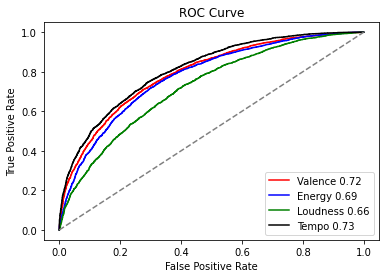

In [12]:
import matplotlib.pyplot as plt

vx, vy, vt = roc_curve(real_valence, prob_valence)
ex, ey, et = roc_curve(real_energy, prob_energy)
lx, ly, lt = roc_curve(real_loudness, prob_loudness)
tx, ty, tt = roc_curve(real_tempo, prob_tempo)


rasv = roc_auc_score(real_valence, pred_valence)
rase = roc_auc_score(real_energy, pred_energy)
rasl = roc_auc_score(real_loudness, pred_loudness)
rast = roc_auc_score(real_tempo, pred_tempo)

plt.plot(vx, vy, color = 'red',   label = f'Valence {round(rasv, 2)}')
plt.plot(ex, ey, color = 'blue',  label = f'Energy {round(rase, 2)}')
plt.plot(lx, ly, color = 'green', label = f'Loudness {round(rasl, 2)}')
plt.plot(tx, ty, color = 'black', label = f'Tempo {round(rast, 2)}')
plt.plot([0, 1], [0, 1], "r--", color = 'gray')
plt.title("ROC Curve")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [13]:
print("Entrada")
pd.DataFrame(entrada_teste[0])

Entrada


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.556575,1.569946,1.795662,1.475,1.033644,1.670683,1.000004,1.153184,1.485972,1.561675,...,1.012512,1.012971,1.00216,1.016667,1.012145,1.011772,1.007982,1.00363,1.01323,1.013986
1,1.556575,1.569946,1.795662,1.300,1.033644,1.670683,1.000004,1.153184,1.485972,1.561675,...,1.012512,1.012971,1.00216,1.016667,1.012145,1.011772,1.007982,1.00363,1.01323,1.013986
2,1.556575,1.569946,1.795662,1.599,1.033644,1.670683,1.000004,1.153184,1.485972,1.561675,...,1.012512,1.012971,1.00216,1.016667,1.012145,1.011772,1.007982,1.00363,1.01323,1.013986
3,1.556575,1.569946,1.795662,1.570,1.033644,1.670683,1.000004,1.153184,1.485972,1.561675,...,1.012512,1.012971,1.00216,1.016667,1.012145,1.011772,1.007982,1.00363,1.01323,1.013986
4,1.556575,1.569946,1.795662,1.228,1.033644,1.670683,1.000004,1.153184,1.485972,1.561675,...,1.012512,1.012971,1.00216,1.016667,1.012145,1.011772,1.007982,1.00363,1.01323,1.013986


In [14]:
final = []
for i in range(len(saida_energy)):
    real = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable([saida_valence[i], saida_energy[i], saida_loudness[i], saida_tempo[i]]))))
    pred = [pred_valence[i], pred_energy[i], pred_loudness[i], pred_tempo[i]]
    final.append(accuracy_score(real, pred))

(array([ 123.,    0.,  843.,    0.,    0., 2219.,    0., 3269.,    0.,
        2437.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

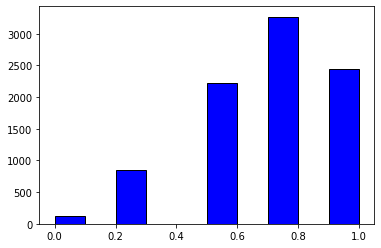

In [15]:
import seaborn as sns
plt.hist(final, color = 'blue', edgecolor = 'black')

In [ ]:
# arr: array com transições; mo: empirically derived markov object, returns log likelihood of arr
ll = 
    function(mo, arr){ t <- log(transitionProbability(mo, arr[1], arr[2]))
                        return( if( length(arr) == 2 ) t else t + ll(mo, arr[2:length(arr)]) )}

# get the mean likelihood of playlist
mll = 
    function(mo, arr){ return (ll(mo, arr)/length(arr)) }

